In [43]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
help(write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [45]:
#define area of interest
query = {
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
    #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
'y': (-35.270, -35.336),
'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2019-01-01', '2019-07-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [46]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 26, x: 663, y: 376)
Coordinates:
  * time             (time) datetime64[ns] 2019-01-04T23:56:20 ... 2019-07-24T23:50:17.500000
  * y                (y) float64 -3.955e+06 -3.955e+06 ... -3.964e+06 -3.964e+06
  * x                (x) float64 1.54e+06 1.54e+06 ... 1.556e+06 1.556e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 8507 8626 8754 8570 ... 240 299 356 503
    blue             (time, y, x) int16 8240 8466 8649 8527 ... 170 222 379 472
    green            (time, y, x) int16 8545 8970 8976 8747 ... 331 513 519 753
    red              (time, y, x) int16 8597 9246 9318 9074 ... 372 666 659 1159
    nir              (time, y, x) int16 9070 9596 9936 9797 ... 2003 1794 1552
    swir1            (time, y, x) int16 6620 6926 6927 6794 ... 1693 1339 1847
    swir2            (time, y, x) int16 5121 5577 5629 5549 ... 1164 860 1588
Attributes:
    crs:      EPSG: 3577

In [47]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

26

In [48]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 26, x: 663, y: 376)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-04T23:56:20 ... 2019-07-24T23:50:17.500000
  * y             (y) float64 -3.955e+06 -3.955e+06 ... -3.964e+06 -3.964e+06
  * x             (x) float64 1.54e+06 1.54e+06 1.54e+06 ... 1.556e+06 1.556e+06
Data variables:
    pixelquality  (time, y, x) int16 13311 13311 13311 ... 16383 16383 16383
Attributes:
    crs:      EPSG: 3577

In [49]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 26, y: 376, x: 663)>
array([[[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-04T23:56:20 ... 2019-07-24T23:50:17.500000
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.964e+06 -3.964e+06
  * x 

In [50]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)


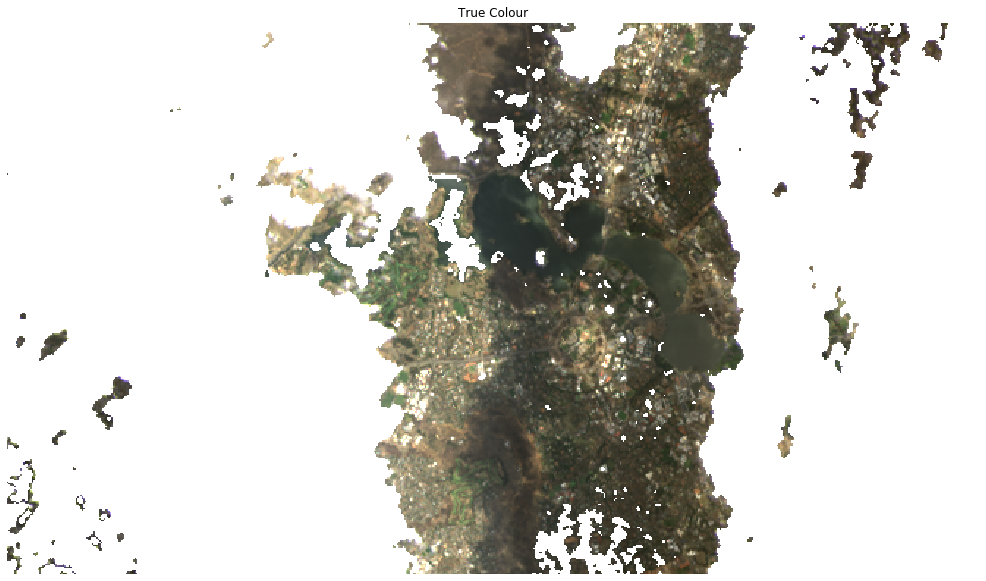

In [51]:
data_lst8_once = Masked_lst8_data.isel(time=0
                                      )

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [52]:
#define area of interest
querywofs = {
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
    #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
'y': (-35.270, -35.336),
'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-01-01', '2018-07-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}

In [53]:
#load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **querywofs)
wofs_water = wofs_filtered_summary['count_wet']
wofs_water

<xarray.DataArray 'count_wet' (time: 1, y: 376, x: 663)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.964e+06 -3.964e+06
  * x        (x) float64 1.54e+06 1.54e+06 1.54e+06 ... 1.556e+06 1.556e+06
Attributes:
    units:    1
    nodata:   -1
    crs:      EPSG: 3577

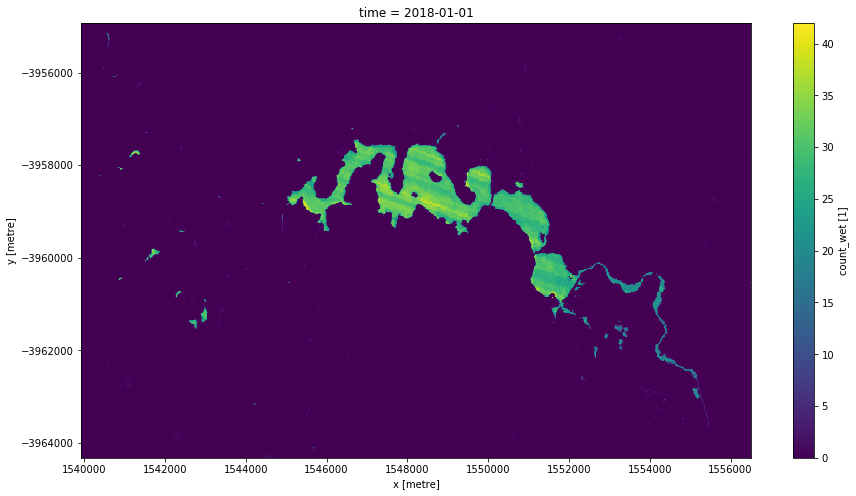

In [54]:
wofs_water.plot(figsize =(15,8))

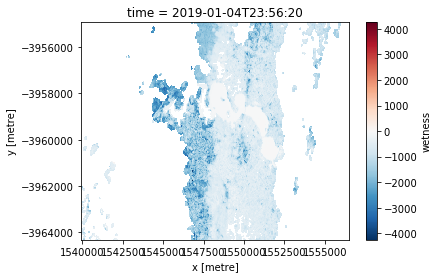

In [55]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']
tcg = TCI['greenness']
tcb = TCI['brightness']

tcw.isel(time=0).plot()

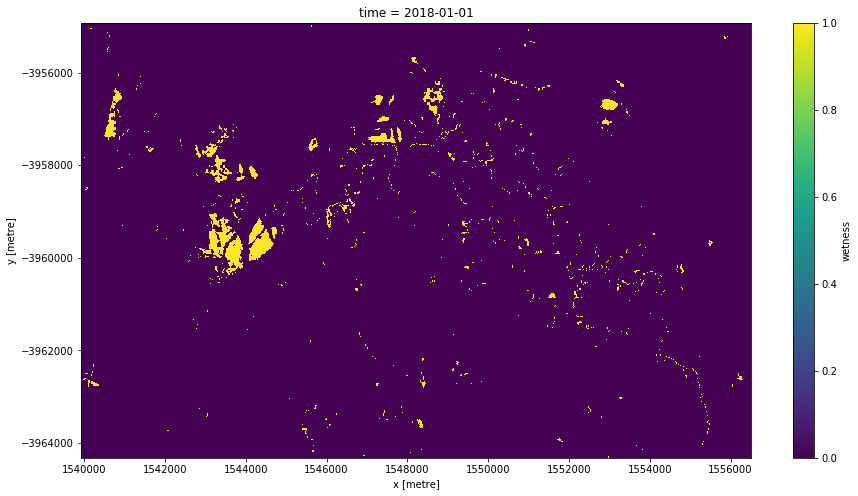

In [56]:
#Apply wet classification over Data

wet_values = tcw.where(tcw<-350, 1) #first turn everything wet to 1
wet_values = wet_values.where(tcw>=-350,0) #then turn everything dry to 0

#stack into wet observations
wet_frequency = wet_values.sum(dim='time')

#Calulate what number of wetness observations is equal to X% of total observations
precent_threhold = total_obs*0.15

#apply threshold
persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)

#mask where WOFS is wet
Inundated_veg = persistant_wet.where(wofs_water<1,0)

#make boolean result
Inundated_veg = Inundated_veg.where(Inundated_veg<=0,1)

#plot
Inundated_veg.plot(figsize =(15,8))

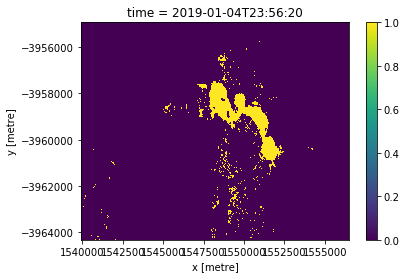

In [57]:
#Apply wet classification over Data WITH GREENESS and Wetness

#create a numpy maks on greeness and wetness

wet_mask2 = (np.logical_and(tcw>=-350,tcg <= 1100)).astype('float64')
wet_mask2.isel(time=0).plot()

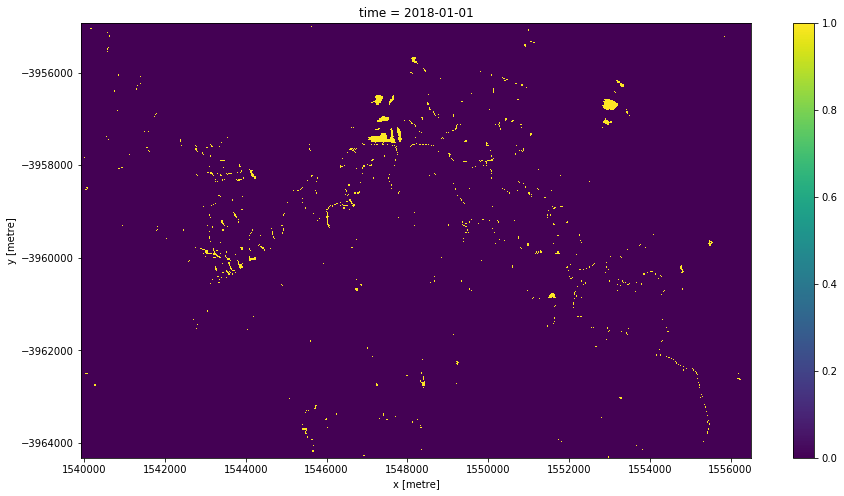

In [58]:


# wet_values2 = tcw.where(tcw<-350 and tcg > 1100, 1) #first turn everything wet to 1
#wet_values2 = wet_values2.where(tcw>=-350 and tcg <= 1100,0) #then turn everything dry to 0

#stack into wet observations
wet_frequency2 = wet_mask2.sum(dim='time')

#Calulate what number of wetness observations is equal to X% of total observations
precent_threhold = total_obs*0.15

#apply threshold
persistant_wet2 = wet_frequency2.where(wet_frequency2>precent_threhold,0)

#mask where WOFS is wet
Inundated_veg2 = persistant_wet2.where(wofs_water<1,0)

#make boolean result
Inundated_veg2 = Inundated_veg2.where(Inundated_veg2<=0,1)

#plot
Inundated_veg2.plot(figsize =(15,8))

In [59]:
#now flattern original dataframe and add in new observations

Out_dataframe = TCI.isel(time=0)
Out_dataframe['wet_only']=Inundated_veg
Out_dataframe['wet_and_green']=Inundated_veg2

Out_dataframe = Out_dataframe.drop(['greenness','greenness_thresholded','brightness_thresholded','brightness','wetness','wetness_thresholded'])
Out_dataframe = Out_dataframe.isel(time=0)
Out_dataframe

<xarray.Dataset>
Dimensions:        (x: 663, y: 376)
Coordinates:
    time           datetime64[ns] 2018-01-01
  * y              (y) float64 -3.955e+06 -3.955e+06 ... -3.964e+06 -3.964e+06
  * x              (x) float64 1.54e+06 1.54e+06 ... 1.556e+06 1.556e+06
Data variables:
    wet_only       (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wet_and_green  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577

In [60]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/ACT_2019_threshold_comparisons.tif',Out_dataframe)